<a href="https://colab.research.google.com/github/uditmanav17/DL-with-Python/blob/master/Chapter_6_2_RNN_for_Text_and_Sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 6.2 Understanding recurrent neural networks
A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept in between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what you did in the IMDB example: an entire movie review was transformed into a single large vector and processed in one go. Such networks are called feedforward networks.

In contrast, as you’re reading the present sentence, you’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence. Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.

A recurrent neural network (RNN) adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop. The state of the RNN is reset between processing two different, independent sequences (such as two different IMDB reviews), so you still consider one sequence a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.

To make these notions of loop and state clear, let’s implement the forward pass of a toy RNN in Numpy. This RNN takes as input a sequence of vectors, which you’ll encode as a 2D tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep, it considers its current state at t and the input at t (of shape (input_ features,), and combines them to obtain the output at t. You’ll then set the state for the next step to be this previous output. For the first timestep, the previous output isn’t defined; hence, there is no current state. So, you’ll initialize the state as an allzero vector called the initial state of the network.

In [0]:
# Numpy implementation of a simple RNN
import numpy as np

timesteps = 100  # number of timesteps in input sequence
input_features = 32  # dimension of input features
output_features = 64  # dimension of output features

# random input generation 
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

# random weight matrix
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.concatenate(successive_outputs, axis=0)
# successive_outputs

### 6.2.1 A recurrent layer in Keras
The process you just naively implemented in Numpy corresponds to an actual Keras layer—the SimpleRNN layer. There is one minor difference: SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence as in the Numpy example. This means it takes inputs of shape (batch_size, timesteps, input_features), rather than (timesteps, input_features). 

Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)) or only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). These two modes are controlled by the return_sequences constructor argument. Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep:

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The following example returns the full state sequence:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return full sequence of outputs

In [0]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now, let’s use such a model on the IMDB movie-review-classification problem. First, preprocess the data.

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)


Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let’s train a simple recurrent network using an Embedding layer and a SimpleRNN layer.

In [0]:
from keras.layers import Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.6278 - acc: 0.6359 - val_loss: 0.5041 - val_acc: 0.7744
Epoch 2/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3874 - acc: 0.8387 - val_loss: 0.4026 - val_acc: 0.8328
Epoch 3/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3006 - acc: 0.8755 - val_loss: 0.3832 - val_acc: 0.8484
Epoch 4/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.2239 - acc: 0.9153 - val_loss: 0.5833 - val_acc: 0.7980
Epoch 5/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.1648 - acc: 0.9417 - val_loss: 0.4093 - val_acc: 0.8382
Epoch 6/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.1106 - acc: 0.9630 - val_loss: 0.4165 - val_acc: 0.8646
Epoch 7/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0740 - acc: 0.9757 - val_loss: 0.5416 - val_acc:

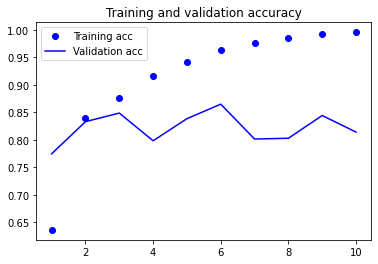

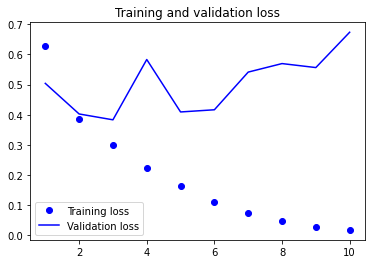

In [0]:
# plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The first naive approach to this dataset got you to a test accuracy of 88%. Unfortunately, this small recurrent network doesn’t perform well compared to this baseline (only 85% validation accuracy). Part of the problem is that your inputs only consider the first 500 words, rather than full sequences—hence, the RNN has access to less information than the earlier baseline model. The remainder of the problem is that SimpleRNN isn’t good at processing long sequences, such as text. Other types of recurrent layers perform much better. Let’s look at some moreadvanced layers.

### 6.2.2 Understanding the LSTM and GRU layers
SimpleRNN isn’t the only recurrent layer available in Keras. There are two others: LSTM and GRU. In practice, you’ll always use one of these, because SimpleRNN is generally too simplistic to be of real use. SimpleRNN has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, in practice, such long-term dependencies are impossible to learn. This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable. The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s. The LSTM and GRU layers are designed to solve this problem.
 
Let’s consider the LSTM layer. The underlying Long Short-Term Memory (LSTM) algorithm was developed by Hochreiter and Schmidhuber in 1997; it was the culmination of their research on the vanishing gradient problem.

This layer is a variant of the SimpleRNN layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.

[A lot is skipped here, better refer to book page 204]()

### 6.2.3 A concrete LSTM example in Keras
Now let’s switch to more practical concerns: you’ll set up a model using an LSTM layer and train it on the IMDB data. The network is similar to the one with SimpleRNN that was just presented. You only specify the output dimensionality of the LSTM layer; leave every other argument (there are many) at the Keras defaults. Keras has good defaults, and things will almost always “just work” without you having to spend time tuning parameters by hand.

In [0]:
# using LSTM layer in keras
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

In [0]:
history = model.fit(input_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 64s 3ms/step - loss: 0.4991 - acc: 0.7667 - val_loss: 0.7757 - val_acc: 0.6850
Epoch 2/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2979 - acc: 0.8853 - val_loss: 0.3388 - val_acc: 0.8594
Epoch 3/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2354 - acc: 0.9103 - val_loss: 0.3808 - val_acc: 0.8530
Epoch 4/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2008 - acc: 0.9268 - val_loss: 0.2960 - val_acc: 0.8896
Epoch 5/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.1827 - acc: 0.9339 - val_loss: 0.3426 - val_acc: 0.8806
Epoch 6/10
20000/20000 [==============================] - 62s 3ms/step - loss: 0.1607 - acc: 0.9422 - val_loss: 0.3409 - val_acc: 0.8720
Epoch 7/10
20000/20000 [==============================] - 62s 3ms/step - loss: 0.1416 - acc: 0.9509 - val_loss: 0.3763 - val_acc:

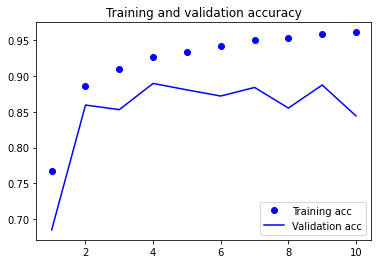

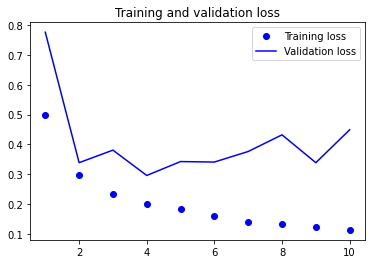

In [0]:
# plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This time, you achieve up to 89% validation accuracy. Not bad: certainly much better than the SimpleRNN network—that’s largely because LSTM suffers much less from the vanishing-gradient problem—and slightly better than the fully connected approach from chapter 3, even though you’re looking at less data than you were in chapter 3. You’re truncating sequences after 500 timesteps, whereas in chapter 3, you were considering full sequences.

But this result isn’t groundbreaking for such a computationally intensive approach. Why isn’t LSTM performing better? One reason is that you made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality. Another may be lack of regularization. But honestly, the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the first fully connected approach looked at. But there are far more difficult naturallanguage-processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation. 

### 6.2.4 Wrapping up
Now you understand the following:
* What RNNs are and how they work
* What LSTM is, and why it works better on long sequences than a naive RNN
* How to use Keras RNN layers to process sequence data

Next, we’ll review a number of more advanced features of RNNs, which can help you get the most out of your deep-learning sequence models.